In [14]:
%reset -f

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import io  # for reading TIFF images
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras_unet_collection import models
from skimage import io  # for reading TIFF images
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils
from tensorflow.keras.optimizers import Adam
from keras.optimizers import *
from keras import backend as K
import time

2024-10-16 00:38:45.317393: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 00:38:45.340530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 00:38:45.340554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 00:38:45.341187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 00:38:45.345379: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set the desired number of patches
desired_num_patches = 7566

# Your data directories
dsm_images_dir = 'DSM_Clip_Patches'
solar_map_dir = 'Solar_Clip_Patches'

# Get the list of file names in the directories without sorting
dsm_files = os.listdir(dsm_images_dir)
solar_map_files = os.listdir(solar_map_dir)



In [3]:
# Initialize empty lists to store data
x_train_list = []
solar_values_list = []


# Loop through each patch with tqdm for progress bars
for i in tqdm(range(min(desired_num_patches, len(dsm_files))), desc='Loading Patches'):
    # Get file names for the current index
    dsm_file = dsm_files[i]
    solar_map_file = solar_map_files[i]
    
    # Load images
    dsm_image = io.imread(os.path.join(dsm_images_dir, dsm_file))
    solar_map = io.imread(os.path.join(solar_map_dir, solar_map_file))

    # Normalize the data using min-max scaling for DSM
    if np.min(dsm_image) != np.max(dsm_image):
        dsm_image_normalized = (dsm_image - np.min(dsm_image)) / (np.max(dsm_image) - np.min(dsm_image))
    else:
        dsm_image_normalized = dsm_image

    # Ensure the shape matches the specified format
    dsm_image_normalized = np.expand_dims(dsm_image_normalized, axis=-1)

    # Expand dimensions for solar map to match the channel dimension
    solar_map = np.expand_dims(solar_map, axis=-1)

    x_train_list.append(dsm_image_normalized)
    solar_values_list.append(solar_map)

    # Break the loop when desired_num_patches is reached
    if len(x_train_list) >= desired_num_patches:
        break

# Combine all patches into single arrays
x_data_dsm = np.stack(x_train_list)
solar_values = np.stack(solar_values_list)

# Ensure the solar values have the correct shape
solar_values = np.squeeze(solar_values, axis=(3,))

# Normalize solar values using min-max scaling
min_solar = np.min(solar_values)
max_solar = np.max(solar_values)
solar_scaled = (solar_values - min_solar) / (max_solar - min_solar)

# Reshape scaled solar values for compatibility with the model
solar_normalized = np.expand_dims(solar_scaled, axis=-1)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data_dsm, solar_normalized, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

# Print the shapes of the datasets
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

input_shape = x_train.shape[1:]


Loading Patches: 100%|█████████▉| 7565/7566 [00:03<00:00, 2219.76it/s]


x_train: (4841, 128, 128, 1)
y_train: (4841, 128, 128, 1)
x_val shape: (1211, 128, 128, 1)
y_val shape: (1211, 128, 128, 1)
x_test shape: (1514, 128, 128, 1)
y_test shape: (1514, 128, 128, 1)


In [5]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Solar-unet3p-attention-3d.hdf5',monitor='val_unet3plus_output_final_activation_mae', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_unet3plus_output_final_activation_mae'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]
model = models.unet_3plus_2d((128, 128, 1), n_labels=1, filter_num_down=[64,128, 256], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=True, deep_supervision=True)


Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 192
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet3plus_output_sup0_activation
	unet3plus_output_sup1_activation
	unet3plus_output_final_activation


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 unet3plus_down0_0 (Conv2D)     (None, 128, 128, 64  576         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 unet3plus_down0_0_bn (BatchNor  (None, 128, 128, 64  256        ['unet3plus_down0_0[0][0]']      
 malization)                    )                                                             

In [7]:
# Train Attention U-Net with generator
model.compile(loss='mean_squared_error',
              
              metrics=['mae'], optimizer=Adam(lr=1e-4))




start_time = time.time()

# Your model training code here
results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=300, callbacks=callbacks)

end_time = time.time()
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60

print("Training completed in {:.2f} seconds ({:.2f} minutes)".format(training_time_seconds, training_time_minutes))


c:\Users\hb\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
152/152 [==============================] - ETA: 0s - loss: 0.1797 - unet3plus_output_sup0_activation_loss: 0.0580 - unet3plus_output_sup1_activation_loss: 0.0622 - unet3plus_output_final_activation_loss: 0.0595 - unet3plus_output_sup0_activation_mae: 0.1844 - unet3plus_output_sup1_activation_mae: 0.1914 - unet3plus_output_final_activation_mae: 0.1869
Epoch 1: val_unet3plus_output_final_activation_mae improved from inf to 0.29165, saving model to Solar-unet3p-attention-3d.hdf5
152/152 [==============================] - 62s 316ms/step - loss: 0.1797 - unet3plus_output_sup0_activation_loss: 0.0580 - unet3plus_output_sup1_activation_loss: 0.0622 - unet3plus_output_final_activation_loss: 0.0595 - unet3plus_output_sup0_activation_mae: 0.1844 - unet3plus_output_sup1_activation_mae: 0.1914 - unet3plus_output_final_activation_mae: 0.1869 - val_loss: 0.3535 - val_unet3plus_output_sup0_activation_loss: 0.1089 - val_unet3plus_output_sup1_activation_loss: 0.1217 - val_unet3plus_output_f

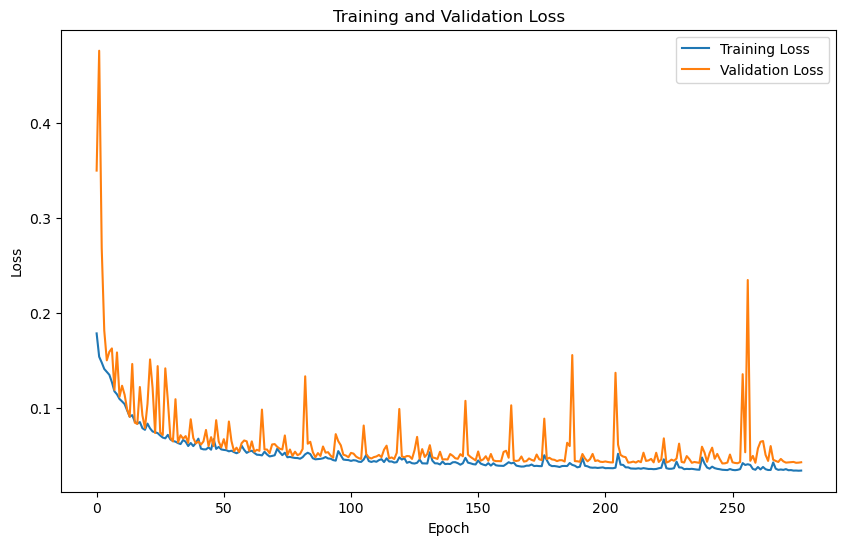

In [8]:
# Plot the loss diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Validation Loss.png', dpi=600, bbox_inches='tight')
plt.show()

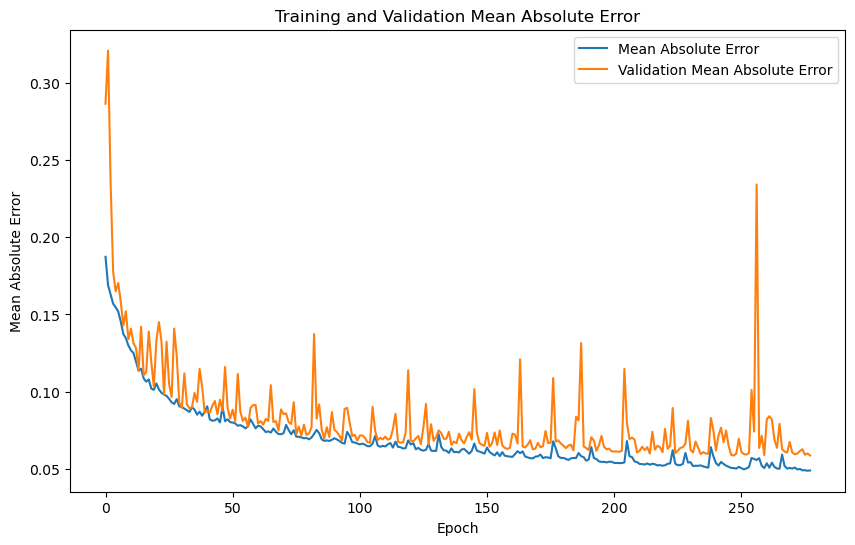

In [9]:
# Plot the accuracy diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['unet3plus_output_final_activation_mae'], label='Mean Absolute Error')
plt.plot(results.history['val_unet3plus_output_final_activation_mae'], label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('Training and Validation Mean Absolute Error.png', dpi=600, bbox_inches='tight')
plt.show()

In [9]:
solar_max = np.max(solar_values)
solar_min = np.min(solar_values)
print(solar_max)
print(solar_min)

1045434.44
0.0


In [10]:
start_time = time.time()
y_pred1 = model.predict(x_test)

end_time = time.time()
x_test_time_seconds = end_time - start_time
x_test_time_minutes = x_test_time_seconds / 60

print("Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_test_time_seconds, x_test_time_minutes))

48/48 [==============================] - 5s 102ms/step
Prediction completed in 5.08 seconds (0.08 minutes)


In [11]:
y_pred10 = y_pred1[-1]

In [13]:
y_pred = y_pred10 * (solar_max - solar_min) + solar_min
y_test2 = y_test * (solar_max - solar_min) + solar_min


In [14]:
# Flatten the arrays
y_test2_flat = y_test2.flatten()
y_pred_flat = y_pred.flatten()

# Calculate R^2
r2 = r2_score(y_test2_flat, y_pred_flat)

In [12]:

start_time = time.time()
y_train_pred = model.predict(x_train)

end_time = time.time()
x_train_time_seconds = end_time - start_time
x_train_time_minutes = x_train_time_seconds / 60

print("x_train_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_train_time_seconds,x_train_time_minutes))

152/152 [==============================] - 15s 99ms/step
x_train_Prediction completed in 15.59 seconds (0.26 minutes)


In [13]:

start_time = time.time()
y_train_pred = model.predict(x_data_dsm)

end_time = time.time()
x_data_dsm_time_seconds = end_time - start_time
x_data_dsm_time_minutes = x_data_dsm_time_seconds / 60

print("x_data_dsm_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_data_dsm_time_seconds,x_data_dsm_time_minutes))

237/237 [==============================] - 23s 99ms/step
x_data_dsm_Prediction completed in 24.37 seconds (0.41 minutes)


In [17]:
y_train_pred2 = y_train_pred[-1]

In [18]:
print(y_train_pred2.shape)

(4841, 128, 128, 1)


In [19]:
# Calculate R^2 for training data

y_train_pred3 = y_train_pred2 * (solar_max - solar_min) + solar_min
y_train2 = y_train * (solar_max - solar_min) + solar_min
# # Flatten the arrays
y_train_pred2_flat = y_train_pred3.flatten()
y_train2_flat = y_train2.flatten()

# Calculate R^2 for training data
r2_train = r2_score(y_train2_flat, y_train_pred2_flat)


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten the arrays
y_train_denormalized_flat =y_train_pred3.flatten()
y_train_pred_flat = y_train2.flatten()

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train_denormalized_flat, y_train_pred_flat))
train_mae = mean_absolute_error(y_train_denormalized_flat, y_train_pred_flat)
train_r2 = r2_score(y_train_denormalized_flat, y_train_pred_flat)

# Flatten the arrays for test data as well
y_test_denormalized_flat = y_test2.flatten()
y_test_pred_flat = y_pred.flatten()

# Calculate metrics for test data
test_rmse = np.sqrt(mean_squared_error(y_test_denormalized_flat, y_test_pred_flat))
test_mae = mean_absolute_error(y_test_denormalized_flat, y_test_pred_flat)
test_r2 = r2_score(y_test_denormalized_flat, y_test_pred_flat)

# Print or use the metrics as needed
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2: {test_r2:.4f}")


Train RMSE: 81129.1641
Train MAE: 50854.2734
Train R2: 0.9340
Test RMSE: 97405.2109
Test MAE: 60106.5156
Test R2: 0.9082


C:\Users\Green\AppData\Local\Temp\ipykernel_6868\4216629586.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('scatter_plot_density_colored_log_inverse_hot.png', dpi=300, bbox_inches='tight')
c:\Users\Green\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


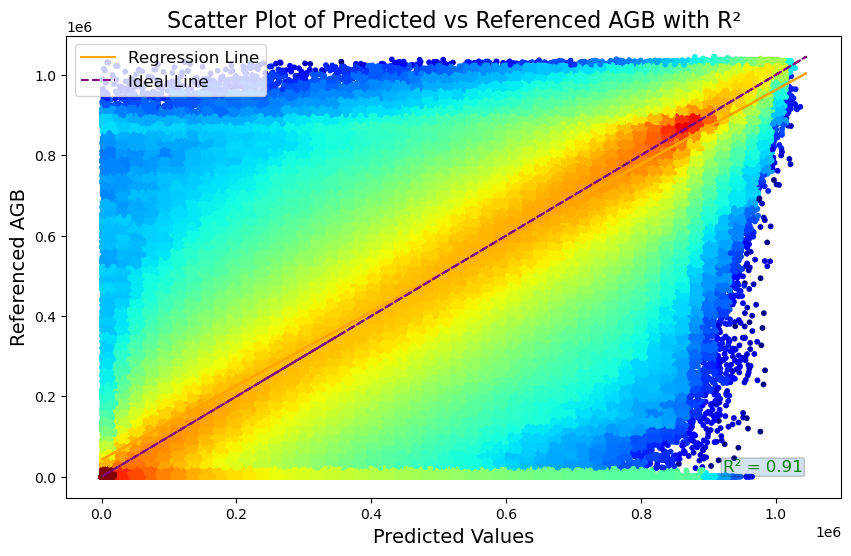

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Reshape arrays if needed
y_test2 = y_test2_flat
y_pred = y_pred_flat

# Create a figure and axis with a larger size
plt.figure(figsize=(10, 6))

# Create a 2D histogram to calculate point density
hist, x_edges, y_edges = np.histogram2d(y_test2, y_pred, bins=(50, 50), density=True)

# Calculate the point density for each point
density = hist[np.clip(np.digitize(y_test2, x_edges) - 1, 0, hist.shape[0] - 1),
               np.clip(np.digitize(y_pred, y_edges) - 1, 0, hist.shape[1] - 1)]

# Use logarithmic scaling for density values
log_density = np.log1p(density)

# Scatter plot with color based on log-scaled density and inverse hot colormap
scatter = plt.scatter(y_pred, y_test2, c=log_density, cmap='jet', s=10, norm=LogNorm())

# Plot true regression line
regression_line = np.polyfit(y_test2, y_pred, 1)
poly_y = np.polyval(regression_line, y_test2)
plt.plot(y_test2, poly_y, color='orange', label='Regression Line')

# Plot ideal line (y = x)
plt.plot(y_test2, y_test2, color='purple', linestyle='--', label='Ideal Line')

# Add labels, legend, and colorbar with larger font sizes
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Referenced AGB', fontsize=14)
plt.title('Scatter Plot of Predicted vs Referenced AGB with R²', fontsize=16)
plt.legend(fontsize=12)

# Annotate R^2 value creatively
annotation_text = f'R² = {r2:.2f}'
plt.annotate(annotation_text, xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=12, ha='right', va='bottom', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Save the plot as a high-quality PNG image with larger font sizes
plt.savefig('scatter_plot_density_colored_log_inverse_hot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
